<a href="https://colab.research.google.com/github/anvargasch/IEStoPRBT/blob/main/IEStoPBRT_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import os                         # función para abrir archivos EXR
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import imageio                    # función para guarda archivos EXR
import cv2                        # libreria de vision por computadora (abrir imagenes, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
import numpy as np                # funciones para matrices
from scipy import interpolate     # funciones para interpolación
from scipy.interpolate import RegularGridInterpolator
import pandas as pd               # funciones para cargar excel

In [ ]:
#Información tipo archivo: http://docs.autodesk.com/ACD/2011/ESP/filesAUG/WS73099cc142f48755f058a10f71c104f3-3b1a.htm

def load_IES(filename):
    with open(filename, 'r') as file:
        content = file.read()
    match = re.search(r'TILT=', content)
    if not match:
        raise ValueError('Formato de archivo IES no válido')
    else:
      file=content.splitlines()
      index=0
      #print(len(file))
      for x in range(len(file)):
        #print(file[x])
        match = re.search(r'TILT=', file[x])
        if match:
          index=x
          x=len(file)
    return file, index # devuelve una lista con el archivo fotométrico e indice en donde inicia TILT

def values (IES, index):
    val=IES[index+1].split()
    Lumen=val[1]
    fact=val[2]
    Num_vert_angle=int(val[3])
    Num_hori_angle=int(val[4])
    unid=int(val[6]) # 1 para pies o 2 para metros
    return (Lumen, fact,Num_vert_angle,Num_hori_angle,unid ) # devuelve parametros de la fotometría

def angles (file,index,num):
    aux=file[index].split()
    angle=np.array(aux)
    N_index = index +1
    N_angles=len(aux)
    if N_angles<num:
      for x in range(len(file)-index):
        aux=file[N_index].split()
        angle2=np.array(aux)
        N_angles=N_angles+len(aux)
        N_index = N_index +1
        angle = np.concatenate((angle, angle2), axis=0)
        if N_angles>=num:
          break
    angle = np.asarray(angle, dtype=float)
    return angle, N_index

def intensity_matrix (file,index,num_ver,num_hor):
    N_index = index
    mat=file[N_index].split()
    for x in range(len(file)-index-1):
      #print(N_index)
      N_index = N_index +1
      aux=file[N_index].split();
      mat=np.concatenate((mat, aux), axis=0)
    mat=np.resize(mat,(num_hor,num_ver))
    #print("Angulos Horizontales :",angle )
    mat = np.asarray(mat, dtype=float)
    return mat.T


In [ ]:
filename = '/content/IESsiemens.ies'  # Reemplazar con el nombre de tu archivo IES /content/IESphilips.ies ,IESsiemens.ies
IES, index = load_IES(filename)
if index!=0:
  Lumen, fact,Num_vert_angle,Num_hori_angle,unid = values (IES, index)
  if Num_vert_angle!=0:
    angle_vertical, index = angles(IES, index+3,Num_vert_angle)
    if Num_hori_angle!=0:
      angle_horizontal, index = angles(IES, index,Num_hori_angle)
      mat=intensity_matrix (IES,index,Num_vert_angle,Num_hori_angle)

print("Lumen:",Lumen,", Factor:", fact,", #Vert:",Num_vert_angle ,", #Horiz:",Num_hori_angle,", Unidades:", unid, "(1:pies, 2:Metros)")
print("Angulos Verticales :",angle_vertical )
print("Angulos Horizontales :",angle_horizontal )
print("Matriz de intensidad :",mat )

Lumen: 3350 , Factor: 1.0 , #Vert: 37 , #Horiz: 7 , Unidades: 2 (1:pies, 2:Metros)
Angulos Verticales : [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180.]
Angulos Horizontales : [ 0. 15. 30. 45. 60. 75. 90.]
Matriz de intensidad : [[128. 128. 128. 128. 128. 128. 128.]
 [128. 128. 128. 128. 128. 127. 126.]
 [129. 128. 128. 128. 128. 126. 124.]
 [130. 128. 127. 127. 127. 124. 121.]
 [131. 128. 125. 125. 125. 121. 117.]
 [134. 129. 124. 124. 124. 117. 111.]
 [137. 130. 122. 122. 122. 113. 105.]
 [140. 130. 120. 120. 120. 109.  97.]
 [143. 130. 118. 118. 118. 103.  89.]
 [144. 130. 116. 116. 116.  98.  80.]
 [145. 129. 114. 113. 113.  92.  70.]
 [145. 128. 110. 110. 110.  85.  60.]
 [144. 125. 107. 106. 106.  78.  49.]
 [142. 122. 102. 102. 102.  70.  39.]
 [139. 118.  97.  96.  96.  62.  28.]
 [133. 112.  90.  90.  90.  54.  18.]
 [126. 104.  82.  82.  

#Ajustar ángulos Verticales
El conjunto de ángulos verticales, en orden creciente. Si la distribución reside totalmente en el hemisferio inferior, los ángulos primero y último deben ser de 0º y 90º respectivamente. Si la distribución reside totalmente en el hemisferio superior, los ángulos primero y último deben ser de 90º y 180º respectivamente. En caso contrario, deben ser de 0º y 180º respectivamente.

In [ ]:
first_angle=angle_vertical[0]
last_angle=angle_vertical[Num_vert_angle-1]

if first_angle==0 and last_angle==90:
  aux=np.linspace(90,180,Num_vert_angle)
  aux=np.delete(aux, 0)
  angle_vertical=np.concatenate((angle_vertical, aux), axis=0)
  aux2=np.zeros((Num_vert_angle-1,Num_hori_angle))
  mat=np.concatenate((mat, aux2), axis=0)
if first_angle==90 and last_angle==180:
  aux=np.linspace(0,90,Num_vert_angle)
  aux=np.delete(aux, 0)
  angle_vertical=np.concatenate((aux,angle_vertical), axis=0)
  aux2=np.zeros((Num_vert_angle-1,Num_hori_angle))
  mat=np.concatenate((aux2,mat), axis=0)


#Ajustar ángulos Horizontales
El conjunto de ángulos horizontales, en orden creciente. El primer ángulo debe ser de 0º. El último ángulo determina el grado de simetría lateral mostrado por la distribución de intensidad. Si es de 0º, la distribución es simétrica en los ejes. Si es de 90º, la distribución es simétrica en cada cuadrante. Si es de 180º, la distribución es simétrica en un plano vertical. Si es mayor de 180º y menor o igual que 360º, la distribución no muestra simetrías laterales. No es válido ningún otro valor.

In [ ]:
first_angle=angle_horizontal[0]
if first_angle==0 and Num_hori_angle==1:
  angle_horizontal=np.linspace(0,90,6)
  Num_hori_angle=angle_horizontal.shape[0]
  aux=np.copy(mat)
  for x in range(Num_hori_angle-1):
    mat=np.concatenate((mat, aux), axis=1)
last_angle=angle_horizontal[Num_hori_angle-1]
if first_angle==0 and last_angle==90:
  aux1=np.linspace(90,180,Num_hori_angle)
  aux1=np.delete(aux1, 0)
  angle_horizontal=np.concatenate((angle_horizontal, aux1), axis=0)
  aux2=mat[:,::-1] ### Espejo
  aux2=np.delete(aux2, 0, axis=1)
  mat=np.concatenate((mat, aux2), axis=1)
  Num_hori_angle=angle_horizontal.shape[0]
  last_angle=angle_horizontal[Num_hori_angle-1]
if first_angle==0 and last_angle==180:
  aux1=np.linspace(180,360,Num_hori_angle)
  aux1=np.delete(aux1, 0)
  angle_horizontal=np.concatenate((angle_horizontal, aux1), axis=0)
  aux2=mat[:,::-1]
  aux2=np.delete(aux2, 0, axis=1)
  mat=np.concatenate((mat, aux2), axis=1)
  Num_hori_angle=angle_horizontal.shape[0]
  last_angle=angle_horizontal[Num_hori_angle-1]


In [ ]:

print(angle_horizontal)

[  0.  18.  36.  54.  72.  90. 108. 126. 144. 162. 180. 198. 216. 234.
 252. 270. 288. 306. 324. 342. 360.]


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

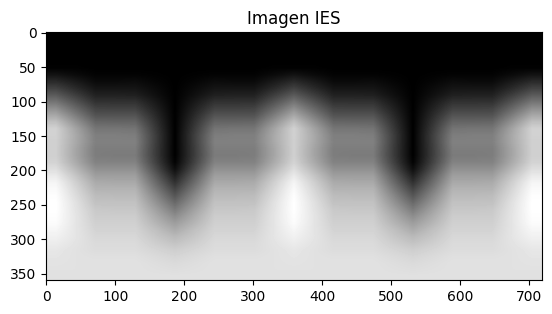

In [ ]:
resized = cv2.resize(mat, (720,360), interpolation = cv2.INTER_LINEAR)
IES=np.rot90(resized, 2)
plt.figure(1)
plt.imshow(IES ,cmap=plt.cm.gray), plt.title("Imagen IES")
plt.imshow

In [ ]:
img_normalized = cv2.normalize(IES, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
IMG_EXR=np.zeros((IES.shape[0], IES.shape[1],3))
IMG_EXR[:,:,0]=img_normalized
IMG_EXR[:,:,1]=img_normalized
IMG_EXR[:,:,2]=img_normalized
IMG_EXR = IMG_EXR.astype("float32")
cv2.imwrite('/content/IMG_EXR10.exr', IMG_EXR)

True

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

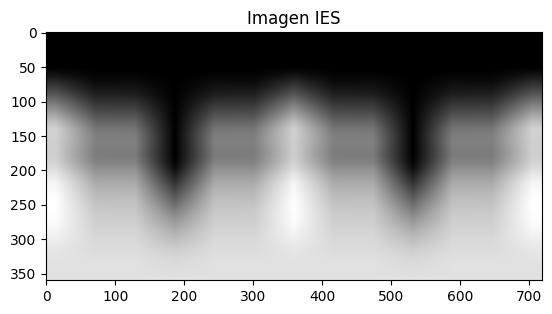

In [ ]:
plt.figure(1)
plt.imshow(IMG_EXR ,cmap=plt.cm.gray), plt.title("Imagen IES")
plt.imshow